In [2]:
%%capture
!pip install ipython-sql 
!pip install networkx

In [35]:
%load_ext autoreload
%autoreload 2
%load_ext sql

import sys

import open3d as o3d
import matplotlib.pyplot as plt
import torch
import h5py

from tqdm import tqdm

from collections import Counter
import pprint


import copy 
import pycolmap

from pathlib import Path
import numpy as np

sys.path.append('/workspace/sk3d/dev.sk_robot_rgbd_data/src')
sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, \
        read_points3D_binary, write_points3D_binary, write_images_binary, read_images_binary, \
        read_cameras_text

from pixsfm import ostream_redirect

from skrgbd.data.io import imgio
from skrgbd.calibration.camera_models import load_colmap_camera
from skrgbd.data.io.poses import load_poses

from skrgbd.data.processing.depth_utils.occluded_mesh_rendering import MeshRenderer

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "all"
print(os.environ["CUDA_VISIBLE_DEVICES"])

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

pp = pprint.PrettyPrinter(depth=4)

all
1.11.0+cu113


In [5]:
scene_name = 'dragon'
delete_previous_output = True

has_cache = True
show_visualization = False

In [6]:
root =  Path('/workspace')

#poses
poses = root / f'datasets/sk3d/dataset/{scene_name}/tis_right/rgb/images.txt'

#cam_model
camera_model = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'

images = root / f'datasets/sk3d/dataset/{scene_name}/tis_right/rgb/undistorted/ambient@best'
outputs = root / f'pixel-perfect-sfm/outputs/{scene_name}/experiment_5'

if delete_previous_output:
    !rm -rf $outputs 
    
outputs.mkdir(parents=True, exist_ok=True)  

if has_cache:
    cache_init = root / f'pixel-perfect-sfm/outputs/caches/{scene_name}/s2dnet_featuremaps_sparse.h5'
    !cp -r $cache_init $outputs
    cache_path = outputs / 's2dnet_featuremaps_sparse.h5'  

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
refined_keypoints = outputs / 'refined_keypoints.h5'
matches = outputs / 'matches.h5'

# refined cameras

!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/experiment_2/features.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/experiment_2/matches.h5 $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/experiment_2/pairs-sfm.txt $outputs
!cp -r /workspace/pixel-perfect-sfm/outputs/dragon/experiment_2/refined/exp_not_refine_cam_params/refined_keypoints.h5 $outputs

!ls $outputs

features.h5  pairs-sfm.txt	   s2dnet_featuremaps_sparse.h5
matches.h5   refined_keypoints.h5


In [7]:
exp5_dir = outputs / 'base'
exp5_dir.mkdir(parents=True, exist_ok=True)

!cp -r $poses $exp5_dir
!cp -r $camera_model $exp5_dir
!touch $exp5_dir/points3D.txt

!ls $exp5_dir

cameras.txt  images.txt  points3D.txt


In [8]:
reconstruction = pycolmap.Reconstruction(exp5_dir)
print(reconstruction.summary())

Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 0
	num_observations = 0
	mean_track_length = 0
	mean_observations_per_image = 0
	mean_reprojection_error = 0


In [9]:
try:
    import hloc
except ImportError:
    print("Could not import hloc.")
    hloc = None

In [11]:
hloc_path = exp5_dir / 'hloc'
hloc_path.mkdir(parents=True, exist_ok=True)

database_path = hloc_path / 'database.db' 

print(database_path)

reference = pycolmap.Reconstruction(exp5_dir)   

images_txt_path = exp5_dir / 'images.txt'
images_dict = read_images_text(images_txt_path)
        
# Here I changed code and in database we have data about camera extrinsics    
image_ids = hloc.triangulation.create_db_from_model(reference, 
                                                    database_path, 
                                                    images_dict)
print(image_ids)



#Importing features into database -> keypoints table 
hloc.triangulation.import_features(image_ids, 
                                   database_path, 
                                   refined_keypoints)


#Importing matches into database -> matches table

skip_geometric_verification = False
hloc.triangulation.import_matches(image_ids, 
                                  database_path, 
                                  sfm_pairs, 
                                  matches,
                                  min_match_score=None, 
                                  skip_geometric_verification=skip_geometric_verification)
#flag skip_geometric_verification == True - add info to two_view_geometry table, same matches are used.



[2022/11/14 06:57:09 hloc WARNING] The database already exists, deleting it.


/workspace/pixel-perfect-sfm/outputs/dragon/experiment_5/base/hloc/database.db


[2022/11/14 06:57:10 hloc INFO] Images info from images dictionary.
[2022/11/14 06:57:10 hloc INFO] Importing features into the database...


{'0000.png': 1, '0001.png': 2, '0002.png': 3, '0003.png': 4, '0004.png': 5, '0005.png': 6, '0006.png': 7, '0007.png': 8, '0008.png': 9, '0009.png': 10, '0010.png': 11, '0011.png': 12, '0012.png': 13, '0013.png': 14, '0014.png': 15, '0015.png': 16, '0016.png': 17, '0017.png': 18, '0018.png': 19, '0019.png': 20, '0020.png': 21, '0021.png': 22, '0022.png': 23, '0023.png': 24, '0024.png': 25, '0025.png': 26, '0026.png': 27, '0027.png': 28, '0028.png': 29, '0029.png': 30, '0030.png': 31, '0031.png': 32, '0032.png': 33, '0033.png': 34, '0034.png': 35, '0035.png': 36, '0036.png': 37, '0037.png': 38, '0038.png': 39, '0039.png': 40, '0040.png': 41, '0041.png': 42, '0042.png': 43, '0043.png': 44, '0044.png': 45, '0045.png': 46, '0046.png': 47, '0047.png': 48, '0048.png': 49, '0049.png': 50, '0050.png': 51, '0051.png': 52, '0052.png': 53, '0053.png': 54, '0054.png': 55, '0055.png': 56, '0056.png': 57, '0057.png': 58, '0058.png': 59, '0059.png': 60, '0060.png': 61, '0061.png': 62, '0062.png': 63, 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 923.43it/s]
[2022/11/14 06:57:10 hloc INFO] Importing matches into the database...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:06<00:00, 726.08it/s]


In [12]:
%reload_ext sql

In [13]:
%sql sqlite:////workspace/pixel-perfect-sfm/outputs/dragon/experiment_5/base/hloc/database.db

In [14]:
 from pixsfm.util.database import blob_to_array

blob = b'\x00\x00\x00\x00\x11\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x02\x00\x00\x00\x06\x00\x00\x00\x04\x00\x00\x00\x07\x00\x00\x00\x05\x00\x00\x00\x08\x00\x00\x00\x06\x00\x00\x00\t\x00\x00\x00\x07\x00\x00\x00\x0b\x00\x00\x00\n\x00\x00\x00\x0c\x00\x00\x00\x0b\x00\x00\x00\r\x00\x00\x00\x0c\x00\x00\x00\x0e\x00\x00\x00\x0e\x00\x00\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x13\x00\x00\x00\x13\x00\x00\x00\x15\x00\x00\x00\x15\x00\x00\x00\x16\x00\x00\x00\x18\x00\x00\x00\x17\x00\x00\x00\x19\x00\x00\x00\x18\x00\x00\x00\x16\x00\x00\x00\x1a\x00\x00\x00\x1f\x00\x00\x00\x1b\x00\x00\x00\x1a\x00\x00\x00\x1c\x00\x00\x00\x1c\x00\x00\x00\x1d\x00\x00\x00%\x00\x00\x00\x1e\x00\x00\x00 \x00\x00\x00\x1f\x00\x00\x00\x1d\x00\x00\x00 \x00\x00\x00!\x00\x00\x00!\x00\x00\x00"\x00\x00\x00"\x00\x00\x00\x1b\x00\x00\x00#\x00\x00\x00\'\x00\x00\x00 \x00\x00\x00&\x00\x00\x00%\x00\x00\x00#\x00\x00\x00&\x00\x00\x00\x1e\x00\x00\x00\'\x00\x00\x00(\x00\x00\x00(\x00\x00\x00*\x00\x00\x00)\x00\x00\x00)\x00\x00\x00*\x00\x00\x00+\x00\x00\x00,\x00\x00\x00-\x00\x00\x00-\x00\x00\x00.\x00\x00\x00.\x00\x00\x002\x00\x00\x000\x00\x00\x00,\x00\x00\x001\x00\x00\x004\x00\x00\x002\x00\x00\x001\x00\x00\x003\x00\x00\x000\x00\x00\x004\x00\x00\x009\x00\x00\x005\x00\x00\x005\x00\x00\x008\x00\x00\x00<\x00\x00\x009\x00\x00\x007\x00\x00\x00:\x00\x00\x003\x00\x00\x00<\x00\x00\x00=\x00\x00\x00=\x00\x00\x00:\x00\x00\x00?\x00\x00\x00A\x00\x00\x00@\x00\x00\x00;\x00\x00\x00C\x00\x00\x00E\x00\x00\x00E\x00\x00\x00@\x00\x00\x00F\x00\x00\x00B\x00\x00\x00G\x00\x00\x00C\x00\x00\x00J\x00\x00\x00?\x00\x00\x00K\x00\x00\x00L\x00\x00\x00L\x00\x00\x00G\x00\x00\x00M\x00\x00\x00M\x00\x00\x00N\x00\x00\x00N\x00\x00\x00P\x00\x00\x00I\x00\x00\x00R\x00\x00\x00R\x00\x00\x00S\x00\x00\x00O\x00\x00\x00T\x00\x00\x00P\x00\x00\x00U\x00\x00\x00T\x00\x00\x00V\x00\x00\x00S\x00\x00\x00W\x00\x00\x00Y\x00\x00\x00X\x00\x00\x00U\x00\x00\x00Y\x00\x00\x00Z\x00\x00\x00Z\x00\x00\x00V\x00\x00\x00\\\x00\x00\x00]\x00\x00\x00]\x00\x00\x00c\x00\x00\x00^\x00\x00\x00a\x00\x00\x00_\x00\x00\x00b\x00\x00\x00`\x00\x00\x00^\x00\x00\x00c\x00\x00\x00_\x00\x00\x00d\x00\x00\x00W\x00\x00\x00f\x00\x00\x00`\x00\x00\x00g\x00\x00\x00\\\x00\x00\x00h\x00\x00\x00g\x00\x00\x00i\x00\x00\x00k\x00\x00\x00j\x00\x00\x00e\x00\x00\x00k\x00\x00\x00n\x00\x00\x00l\x00\x00\x00j\x00\x00\x00m\x00\x00\x00l\x00\x00\x00n\x00\x00\x00h\x00\x00\x00q\x00\x00\x00t\x00\x00\x00s\x00\x00\x00q\x00\x00\x00u\x00\x00\x00u\x00\x00\x00v\x00\x00\x00m\x00\x00\x00w\x00\x00\x00f\x00\x00\x00x\x00\x00\x00x\x00\x00\x00y\x00\x00\x00y\x00\x00\x00z\x00\x00\x00v\x00\x00\x00|\x00\x00\x00p\x00\x00\x00~\x00\x00\x00w\x00\x00\x00\x7f\x00\x00\x00}\x00\x00\x00\x80\x00\x00\x00{\x00\x00\x00\x81\x00\x00\x00r\x00\x00\x00\x82\x00\x00\x00\x81\x00\x00\x00\x83\x00\x00\x00|\x00\x00\x00\x86\x00\x00\x00~\x00\x00\x00\x88\x00\x00\x00\x84\x00\x00\x00\x89\x00\x00\x00\x85\x00\x00\x00\x8a\x00\x00\x00\x7f\x00\x00\x00\x8c\x00\x00\x00\x8c\x00\x00\x00\x8d\x00\x00\x00\x80\x00\x00\x00\x8f\x00\x00\x00\x87\x00\x00\x00\x90\x00\x00\x00\x88\x00\x00\x00\x92\x00\x00\x00\x89\x00\x00\x00\x93\x00\x00\x00\x8a\x00\x00\x00\x94\x00\x00\x00\x83\x00\x00\x00\x95\x00\x00\x00\x90\x00\x00\x00\x96\x00\x00\x00\x8e\x00\x00\x00\x97\x00\x00\x00\x8b\x00\x00\x00\x98\x00\x00\x00\x94\x00\x00\x00\x99\x00\x00\x00\x8f\x00\x00\x00\x9a\x00\x00\x00\x91\x00\x00\x00\x9b\x00\x00\x00\x92\x00\x00\x00\x9d\x00\x00\x00\x99\x00\x00\x00\x9e\x00\x00\x00\x98\x00\x00\x00\x9f\x00\x00\x00\x97\x00\x00\x00\xa0\x00\x00\x00\x9a\x00\x00\x00\xa1\x00\x00\x00\x93\x00\x00\x00\xa3\x00\x00\x00\x95\x00\x00\x00\xa4\x00\x00\x00\x9e\x00\x00\x00\xa5\x00\x00\x00\x9b\x00\x00\x00\xa6\x00\x00\x00\x9f\x00\x00\x00\xa7\x00\x00\x00\x9c\x00\x00\x00\xa9\x00\x00\x00\xab\x00\x00\x00\xaa\x00\x00\x00\xa0\x00\x00\x00\xab\x00\x00\x00\xac\x00\x00\x00\xac\x00\x00\x00\xa7\x00\x00\x00\xad\x00\x00\x00\xa4\x00\x00\x00\xae\x00\x00\x00\xa5\x00\x00\x00\xaf\x00\x00\x00\xae\x00\x00\x00\xb1\x00\x00\x00\xa1\x00\x00\x00\xb2\x00\x00\x00\xa2\x00\x00\x00\xb3\x00\x00\x00\xa3\x00\x00\x00\xb7\x00\x00\x00\xa6\x00\x00\x00\xb8\x00\x00\x00\xaf\x00\x00\x00\xb9\x00\x00\x00\xad\x00\x00\x00\xba\x00\x00\x00\xa8\x00\x00\x00\xbb\x00\x00\x00\xb7\x00\x00\x00\xbc\x00\x00\x00\xb2\x00\x00\x00\xbd\x00\x00\x00\xaa\x00\x00\x00\xbe\x00\x00\x00\xbd\x00\x00\x00\xbf\x00\x00\x00\xba\x00\x00\x00\xc0\x00\x00\x00\xbb\x00\x00\x00\xc1\x00\x00\x00\xbe\x00\x00\x00\xc2\x00\x00\x00\xc2\x00\x00\x00\xc3\x00\x00\x00\xbc\x00\x00\x00\xc5\x00\x00\x00\xb4\x00\x00\x00\xc6\x00\x00\x00\xc3\x00\x00\x00\xc7\x00\x00\x00\xc4\x00\x00\x00\xc8\x00\x00\x00\xb9\x00\x00\x00\xca\x00\x00\x00\xb6\x00\x00\x00\xcb\x00\x00\x00\xc9\x00\x00\x00\xcc\x00\x00\x00\xc0\x00\x00\x00\xcd\x00\x00\x00\xc6\x00\x00\x00\xce\x00\x00\x00\xc5\x00\x00\x00\xcf\x00\x00\x00\xca\x00\x00\x00\xd0\x00\x00\x00\xce\x00\x00\x00\xd1\x00\x00\x00\xcb\x00\x00\x00\xd5\x00\x00\x00\xd8\x00\x00\x00\xd6\x00\x00\x00\xcd\x00\x00\x00\xd7\x00\x00\x00\xc7\x00\x00\x00\xd9\x00\x00\x00\xcc\x00\x00\x00\xda\x00\x00\x00\xc8\x00\x00\x00\xdb\x00\x00\x00\xd0\x00\x00\x00\xdd\x00\x00\x00\xe0\x00\x00\x00\xde\x00\x00\x00\xe1\x00\x00\x00\xe1\x00\x00\x00\xd9\x00\x00\x00\xe2\x00\x00\x00\xd5\x00\x00\x00\xe3\x00\x00\x00\xd1\x00\x00\x00\xe4\x00\x00\x00\xd2\x00\x00\x00\xe5\x00\x00\x00\xe2\x00\x00\x00\xe6\x00\x00\x00\xde\x00\x00\x00\xe7\x00\x00\x00\xd6\x00\x00\x00\xe9\x00\x00\x00\xd3\x00\x00\x00\xea\x00\x00\x00\xd4\x00\x00\x00\xeb\x00\x00\x00\xe7\x00\x00\x00\xec\x00\x00\x00\xe8\x00\x00\x00\xed\x00\x00\x00\xe4\x00\x00\x00\xef\x00\x00\x00\xdf\x00\x00\x00\xf0\x00\x00\x00\xe3\x00\x00\x00\xf4\x00\x00\x00\xee\x00\x00\x00\xf5\x00\x00\x00\xec\x00\x00\x00\xf8\x00\x00\x00\xe9\x00\x00\x00\xf9\x00\x00\x00\xe6\x00\x00\x00\xfa\x00\x00\x00\xf2\x00\x00\x00\xfc\x00\x00\x00\xf4\x00\x00\x00\xfd\x00\x00\x00\xeb\x00\x00\x00\xfe\x00\x00\x00\xf0\x00\x00\x00\xff\x00\x00\x00\xed\x00\x00\x00\x00\x01\x00\x00\xef\x00\x00\x00\x01\x01\x00\x00\xf8\x00\x00\x00\x02\x01\x00\x00\xf5\x00\x00\x00\x03\x01\x00\x00\xf1\x00\x00\x00\x04\x01\x00\x00\xfa\x00\x00\x00\x05\x01\x00\x00\xfc\x00\x00\x00\x06\x01\x00\x00\xf6\x00\x00\x00\x07\x01\x00\x00\xf7\x00\x00\x00\t\x01\x00\x00\xff\x00\x00\x00\n\x01\x00\x00\xfd\x00\x00\x00\x0b\x01\x00\x00\x00\x01\x00\x00\r\x01\x00\x00\x04\x01\x00\x00\x0e\x01\x00\x00\xfe\x00\x00\x00\x0f\x01\x00\x00\xfb\x00\x00\x00\x10\x01\x00\x00\x08\x01\x00\x00\x11\x01\x00\x00\x03\x01\x00\x00\x13\x01\x00\x00\n\x01\x00\x00\x14\x01\x00\x00\x07\x01\x00\x00\x16\x01\x00\x00\t\x01\x00\x00\x17\x01\x00\x00\x0b\x01\x00\x00\x18\x01\x00\x00\x05\x01\x00\x00\x19\x01\x00\x00\x01\x01\x00\x00\x1a\x01\x00\x00\x19\x01\x00\x00\x1b\x01\x00\x00\x11\x01\x00\x00\x1c\x01\x00\x00\x0c\x01\x00\x00\x1d\x01\x00\x00\x06\x01\x00\x00\x1e\x01\x00\x00\x12\x01\x00\x00\x1f\x01\x00\x00\x0f\x01\x00\x00 \x01\x00\x00\x0e\x01\x00\x00"\x01\x00\x00\x1a\x01\x00\x00#\x01\x00\x00\x1b\x01\x00\x00%\x01\x00\x00\x10\x01\x00\x00&\x01\x00\x00\x16\x01\x00\x00\'\x01\x00\x00\x17\x01\x00\x00(\x01\x00\x00\x13\x01\x00\x00*\x01\x00\x00\x14\x01\x00\x00.\x01\x00\x00!\x01\x00\x00/\x01\x00\x00\x18\x01\x00\x000\x01\x00\x00\x1c\x01\x00\x001\x01\x00\x00)\x01\x00\x002\x01\x00\x00\'\x01\x00\x005\x01\x00\x00\x1f\x01\x00\x006\x01\x00\x00#\x01\x00\x008\x01\x00\x00 \x01\x00\x009\x01\x00\x00-\x01\x00\x00:\x01\x00\x00%\x01\x00\x00;\x01\x00\x00"\x01\x00\x00<\x01\x00\x00/\x01\x00\x00=\x01\x00\x002\x01\x00\x00>\x01\x00\x00,\x01\x00\x00?\x01\x00\x008\x01\x00\x00A\x01\x00\x000\x01\x00\x00B\x01\x00\x001\x01\x00\x00C\x01\x00\x00&\x01\x00\x00D\x01\x00\x009\x01\x00\x00E\x01\x00\x004\x01\x00\x00F\x01\x00\x00@\x01\x00\x00G\x01\x00\x00<\x01\x00\x00J\x01\x00\x006\x01\x00\x00K\x01\x00\x007\x01\x00\x00L\x01\x00\x00;\x01\x00\x00M\x01\x00\x00B\x01\x00\x00O\x01\x00\x00>\x01\x00\x00P\x01\x00\x00C\x01\x00\x00R\x01\x00\x00=\x01\x00\x00S\x01\x00\x00?\x01\x00\x00T\x01\x00\x00:\x01\x00\x00U\x01\x00\x00D\x01\x00\x00V\x01\x00\x00A\x01\x00\x00W\x01\x00\x00X\x01\x00\x00X\x01\x00\x00G\x01\x00\x00\\\x01\x00\x00M\x01\x00\x00]\x01\x00\x00F\x01\x00\x00^\x01\x00\x00Y\x01\x00\x00_\x01\x00\x00V\x01\x00\x00`\x01\x00\x00H\x01\x00\x00a\x01\x00\x00J\x01\x00\x00b\x01\x00\x00N\x01\x00\x00c\x01\x00\x00I\x01\x00\x00d\x01\x00\x00W\x01\x00\x00e\x01\x00\x00_\x01\x00\x00g\x01\x00\x00[\x01\x00\x00h\x01\x00\x00\\\x01\x00\x00i\x01\x00\x00O\x01\x00\x00k\x01\x00\x00P\x01\x00\x00l\x01\x00\x00Q\x01\x00\x00m\x01\x00\x00R\x01\x00\x00n\x01\x00\x00S\x01\x00\x00o\x01\x00\x00T\x01\x00\x00p\x01\x00\x00]\x01\x00\x00q\x01\x00\x00b\x01\x00\x00r\x01\x00\x00`\x01\x00\x00t\x01\x00\x00^\x01\x00\x00u\x01\x00\x00g\x01\x00\x00v\x01\x00\x00j\x01\x00\x00w\x01\x00\x00c\x01\x00\x00x\x01\x00\x00d\x01\x00\x00y\x01\x00\x00h\x01\x00\x00{\x01\x00\x00u\x01\x00\x00|\x01\x00\x00l\x01\x00\x00}\x01\x00\x00\x7f\x01\x00\x00~\x01\x00\x00v\x01\x00\x00\x80\x01\x00\x00i\x01\x00\x00\x81\x01\x00\x00w\x01\x00\x00\x82\x01\x00\x00q\x01\x00\x00\x84\x01\x00\x00m\x01\x00\x00\x85\x01\x00\x00k\x01\x00\x00\x86\x01\x00\x00|\x01\x00\x00\x88\x01\x00\x00o\x01\x00\x00\x89\x01\x00\x00s\x01\x00\x00\x8a\x01\x00\x00a\x01\x00\x00\x8b\x01\x00\x00x\x01\x00\x00\x8c\x01\x00\x00z\x01\x00\x00\x8d\x01\x00\x00\x82\x01\x00\x00\x8e\x01\x00\x00\x95\x01\x00\x00\x8f\x01\x00\x00}\x01\x00\x00\x90\x01\x00\x00{\x01\x00\x00\x91\x01\x00\x00y\x01\x00\x00\x92\x01\x00\x00t\x01\x00\x00\x94\x01\x00\x00\x83\x01\x00\x00\x96\x01\x00\x00\x88\x01\x00\x00\x97\x01\x00\x00\x85\x01\x00\x00\x98\x01\x00\x00\x80\x01\x00\x00\x99\x01\x00\x00~\x01\x00\x00\x9b\x01\x00\x00\x8a\x01\x00\x00\x9d\x01\x00\x00\x8e\x01\x00\x00\x9e\x01\x00\x00\x86\x01\x00\x00\x9f\x01\x00\x00\x8b\x01\x00\x00\xa1\x01\x00\x00\x8c\x01\x00\x00\xa2\x01\x00\x00\x89\x01\x00\x00\xa3\x01\x00\x00\x9d\x01\x00\x00\xa4\x01\x00\x00\x99\x01\x00\x00\xa5\x01\x00\x00\x91\x01\x00\x00\xa6\x01\x00\x00\x8f\x01\x00\x00\xa7\x01\x00\x00\xa0\x01\x00\x00\xa8\x01\x00\x00\x92\x01\x00\x00\xa9\x01\x00\x00\x9e\x01\x00\x00\xaa\x01\x00\x00\x9f\x01\x00\x00\xab\x01\x00\x00\x9b\x01\x00\x00\xad\x01\x00\x00\x97\x01\x00\x00\xae\x01\x00\x00\xa9\x01\x00\x00\xaf\x01\x00\x00\xa5\x01\x00\x00\xb0\x01\x00\x00\xa3\x01\x00\x00\xb1\x01\x00\x00\xa2\x01\x00\x00\xb2\x01\x00\x00\xa6\x01\x00\x00\xb3\x01\x00\x00\x9c\x01\x00\x00\xb4\x01\x00\x00\x98\x01\x00\x00\xb9\x01\x00\x00\xa7\x01\x00\x00\xbc\x01\x00\x00\xad\x01\x00\x00\xbd\x01\x00\x00\xb1\x01\x00\x00\xbe\x01\x00\x00\xa8\x01\x00\x00\xbf\x01\x00\x00\xaa\x01\x00\x00\xc0\x01\x00\x00\xbd\x01\x00\x00\xc1\x01\x00\x00\xb3\x01\x00\x00\xc2\x01\x00\x00\xab\x01\x00\x00\xc3\x01\x00\x00\xbe\x01\x00\x00\xc4\x01\x00\x00\xb4\x01\x00\x00\xc7\x01\x00\x00\xaf\x01\x00\x00\xc8\x01\x00\x00\xac\x01\x00\x00\xc9\x01\x00\x00\xb0\x01\x00\x00\xca\x01\x00\x00\xc1\x01\x00\x00\xcb\x01\x00\x00\xc2\x01\x00\x00\xcc\x01\x00\x00\xb6\x01\x00\x00\xcd\x01\x00\x00\xb8\x01\x00\x00\xce\x01\x00\x00\xb7\x01\x00\x00\xcf\x01\x00\x00\xb9\x01\x00\x00\xd0\x01\x00\x00\xc5\x01\x00\x00\xd1\x01\x00\x00\xba\x01\x00\x00\xd2\x01\x00\x00\xc6\x01\x00\x00\xd4\x01\x00\x00\xbb\x01\x00\x00\xd5\x01\x00\x00\xb2\x01\x00\x00\xd6\x01\x00\x00\xbc\x01\x00\x00\xd7\x01\x00\x00\xc9\x01\x00\x00\xd8\x01\x00\x00\xc0\x01\x00\x00\xd9\x01\x00\x00\xc7\x01\x00\x00\xda\x01\x00\x00\xc3\x01\x00\x00\xdb\x01\x00\x00\xc8\x01\x00\x00\xdc\x01\x00\x00\xc4\x01\x00\x00\xdd\x01\x00\x00\xcf\x01\x00\x00\xde\x01\x00\x00\xcc\x01\x00\x00\xdf\x01\x00\x00\xca\x01\x00\x00\xe0\x01\x00\x00\xd7\x01\x00\x00\xe1\x01\x00\x00\xd1\x01\x00\x00\xe2\x01\x00\x00\xd0\x01\x00\x00\xe4\x01\x00\x00\xcd\x01\x00\x00\xe5\x01\x00\x00\xcb\x01\x00\x00\xe7\x01\x00\x00\xd3\x01\x00\x00\xe8\x01\x00\x00\xce\x01\x00\x00\xe9\x01\x00\x00\xd6\x01\x00\x00\xea\x01\x00\x00\xd4\x01\x00\x00\xed\x01\x00\x00\xdc\x01\x00\x00\xee\x01\x00\x00\xd8\x01\x00\x00\xef\x01\x00\x00\xd2\x01\x00\x00\xf0\x01\x00\x00\xd9\x01\x00\x00\xf2\x01\x00\x00\xda\x01\x00\x00\xf3\x01\x00\x00\xdb\x01\x00\x00\xf4\x01\x00\x00\xe0\x01\x00\x00\xf7\x01\x00\x00\xe4\x01\x00\x00\xf9\x01\x00\x00\xe3\x01\x00\x00\xfa\x01\x00\x00\xe2\x01\x00\x00\xfc\x01\x00\x00\xe5\x01\x00\x00\xfe\x01\x00\x00\xe6\x01\x00\x00\x00\x02\x00\x00\xea\x01\x00\x00\x01\x02\x00\x00\xee\x01\x00\x00\x04\x02\x00\x00\xec\x01\x00\x00\x06\x02\x00\x00\xf5\x01\x00\x00\x07\x02\x00\x00\xef\x01\x00\x00\t\x02\x00\x00\xf0\x01\x00\x00\n\x02\x00\x00\xf3\x01\x00\x00\x0b\x02\x00\x00\xfd\x01\x00\x00\x0c\x02\x00\x00\xff\x01\x00\x00\x0e\x02\x00\x00\xfe\x01\x00\x00\x0f\x02\x00\x00\xf7\x01\x00\x00\x10\x02\x00\x00\xf9\x01\x00\x00\x11\x02\x00\x00\x07\x02\x00\x00\x12\x02\x00\x00\xf1\x01\x00\x00\x14\x02\x00\x00\xfc\x01\x00\x00\x15\x02\x00\x00\x06\x02\x00\x00\x16\x02\x00\x00\xfb\x01\x00\x00\x17\x02\x00\x00\x00\x02\x00\x00\x18\x02\x00\x00\x01\x02\x00\x00\x19\x02\x00\x00\x02\x02\x00\x00\x1c\x02\x00\x00\x10\x02\x00\x00\x1d\x02\x00\x00\x04\x02\x00\x00\x1e\x02\x00\x00\t\x02\x00\x00\x1f\x02\x00\x00\r\x02\x00\x00"\x02\x00\x00\x0f\x02\x00\x00$\x02\x00\x00\x0b\x02\x00\x00'
blob_to_array(blob, np.uint32, (-1, 2)).shape

(422, 2)

In [15]:
%%sql

select count(*) from matches limit 1;

 * sqlite:////workspace/pixel-perfect-sfm/outputs/dragon/experiment_5/base/hloc/database.db
Done.


count(*)
4950


In [16]:
%%sql

select sum(rows), count(*) from matches;

 * sqlite:////workspace/pixel-perfect-sfm/outputs/dragon/experiment_5/base/hloc/database.db
Done.


sum(rows),count(*)
1376794,4950


In [17]:
%%sql

select sum(rows), count(*) from two_view_geometries;

 * sqlite:////workspace/pixel-perfect-sfm/outputs/dragon/experiment_5/base/hloc/database.db
Done.


sum(rows),count(*)
None,0


In [ ]:
estimate_two_view_geometries = False
verbose = True

if not skip_geometric_verification:
        if estimate_two_view_geometries:
            hloc.triangulation.estimation_and_geometric_verification(database_path, 
                                                  sfm_pairs, 
                                                  verbose)
        else:
            hloc.triangulation.geometric_verification(
                image_ids, 
                reference, 
                database_path, 
                features, 
                sfm_pairs, 
                matches)
            
# output ->  mean/med/min/max valid matches 98.71/99.13/65.79/100.00%.            
            

Define 2D keypoints.
A keypoint at the upper left corner of the upper left pixel would have coords `(0, 0)`, and
a keypoint at the lower right corner of the lower right pixel would have coords `(width, height)`.

In [18]:
from pixsfm.util.colmap import read_keypoints_from_db, read_matches_from_db, write_keypoints_to_db

keypoints = read_keypoints_from_db(database_path)

# the order in matches list is the same as in pairs
pairs, matches, scores = read_matches_from_db(database_path)

In [ ]:
# repeating code from graph section
# they put unique feature_idx for all features.

Load data: scan, camera model, camera poses.

In [19]:
sk3d_root = '/workspace/datasets/sk3d'

dtype = torch.float
device = 'cpu'

rec = f'{sk3d_root}/dataset/{scene_name}/stl/reconstruction/cleaned.ply'
rec = o3d.io.read_triangle_mesh(rec)

occ = f'{sk3d_root}/dataset/{scene_name}/stl/occluded_space.ply'
occ = o3d.io.read_triangle_mesh(occ)

renderer = MeshRenderer(rec, occ); del occ

cam_model = f'{sk3d_root}/dataset/calibration/tis_right/rgb/cameras.txt'
cam_model = load_colmap_camera(cam_model).to(device, dtype)

poses = f'{sk3d_root}/dataset/{scene_name}/tis_right/rgb/images.txt'
world_to_cam = load_poses(poses, dtype).to(device, dtype)

tensor([[1705.4896,  167.6432],
        [ 121.1921,  367.6489],
        [1116.6553,  383.1153],
        ...,
        [2128.8140, 1906.1631],
        [ 685.5000, 1913.5000],
        [1761.4961, 1914.9709]], dtype=torch.float32)


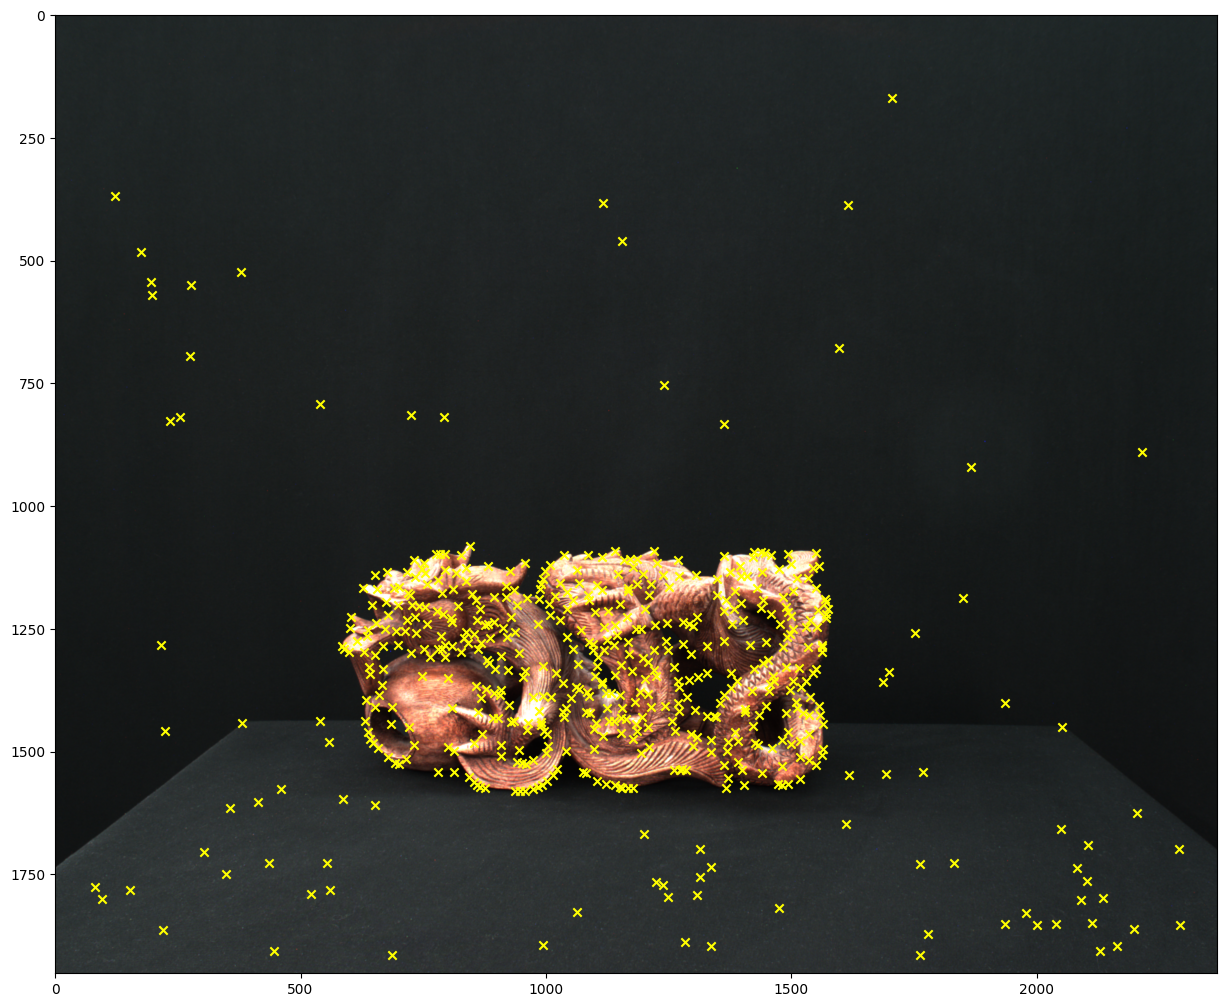

In [20]:
view_i = 0

key_pts = torch.tensor(keypoints['0000.png'], dtype=dtype)  # [[x1, y1], [x2, y2], ...]

# Visualize keypoints
img = f'{sk3d_root}/dataset/{scene_name}/tis_right/rgb/undistorted/ambient@best/{view_i:04}.png'
img = imgio.read.tis_right.rgb(img)

plt.figure(figsize=[15]*2)
plt.imshow(img)

print(key_pts)

plt.scatter(key_pts[:, 0], key_pts[:, 1], marker='x', c='yellow')

Trace rays. Keep only keypoints with a finite hit depth.

ray_dirs_in_cam_space = cam_model.unproject(key_pts.T.to(device, dtype))  # shape is 3, pts_n
pts_n = ray_dirs_in_cam_space.shape[1]

cam_to_world = world_to_cam[view_i].inverse()  # 4, 4
cam_center_in_world_space = cam_to_world[:3, 3]  # 3
ray_origins_in_world_space = cam_center_in_world_space.unsqueeze(0).expand(pts_n, -1)  # pts_n, 3
cam_to_world_rot = cam_to_world[:3, :3]
ray_dirs_in_world_space = ray_dirs_in_cam_space.T @ cam_to_world_rot.T  # pts_n, 3

casted_rays = torch.cat([ray_origins_in_world_space, ray_dirs_in_world_space], 1)  # pts_n, 6
renderer.occ_threshold = 1e-3

hit_depth = renderer.render_rays(casted_rays, cull_back_faces=True)['ray_hit_depth']
print(hit_depth)
print(hit_depth.shape)

did_hit = hit_depth.isfinite()
pts_3d = (ray_dirs_in_world_space * hit_depth.unsqueeze(1) + ray_origins_in_world_space)[did_hit]
print(len(pts_3d))

Save and check.

pc = o3d.geometry.PointCloud()
pc.points.extend(pts_3d.double().numpy())

o3d.io.write_point_cloud(str(outputs / 'pts.ply'), pc)
o3d.io.write_triangle_mesh(str(outputs / 'scan.ply'), rec)

In [21]:
key_pts_3d_pts = {}
idx_to_remove_dict = {}

for image_id, image in reconstruction.images.items():
    
    key_pts = torch.tensor(keypoints[image.name], dtype=dtype)
    
    ray_dirs_in_cam_space = cam_model.unproject(key_pts.T.to(device, dtype))  # shape is 3, pts_n
    pts_n = ray_dirs_in_cam_space.shape[1]

    cam_to_world = world_to_cam[view_i].inverse()  # 4, 4
    cam_center_in_world_space = cam_to_world[:3, 3]  # 3
    ray_origins_in_world_space = cam_center_in_world_space.unsqueeze(0).expand(pts_n, -1)  # pts_n, 3
    cam_to_world_rot = cam_to_world[:3, :3]
    ray_dirs_in_world_space = ray_dirs_in_cam_space.T @ cam_to_world_rot.T  # pts_n, 3

    casted_rays = torch.cat([ray_origins_in_world_space, ray_dirs_in_world_space], 1)  # pts_n, 6
    renderer.occ_threshold = 1e-3
    
    hit_depth = renderer.render_rays(casted_rays, cull_back_faces=True)['ray_hit_depth']
    
    did_hit = hit_depth.isfinite()
    idx_to_remove = (did_hit==False).nonzero().squeeze()
    
    pts_3d = (ray_dirs_in_world_space * hit_depth.unsqueeze(1) + ray_origins_in_world_space)[did_hit]
    upd_key_pts = key_pts[did_hit]
    
    key_pts_3d_pts[image.name] = list(zip(pts_3d, upd_key_pts)) 
    idx_to_remove_dict[image.name] = idx_to_remove.numpy()

In [22]:
for idx, (name1, name2) in tqdm(enumerate(pairs)):
    indices = [] 
    collect_matches = []
    for k, (idx1, idx2) in enumerate(list(matches[idx])):
        if idx1 not in idx_to_remove_dict[name1] and idx2 not in idx_to_remove_dict[name2]:
            collect_matches.append(np.asarray([idx1, idx2]))
    matches[idx] = np.asarray(collect_matches)

4950it [00:20, 235.90it/s]


In [ ]:
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.remove_edge.html
# https://www.idtools.com.au/3d-network-graphs-with-python-and-the-mplot3d-toolkit/

In [37]:
from pixsfm.keypoint_adjustment import build_matching_graph
from pixsfm import base, features, logger


graph = base.Graph()
scores = [None for _ in matches]

for (name1, name2), m, s in zip(pairs, matches, scores):
    graph.register_matches(name1, name2, m, s)   

print(graph)

I compute track labels to see how many graph nodes, grap edges, tracks I have. Each track has its own index, here we have 1310 tracks,

In [24]:
# Label graph
track_labels = base.compute_track_labels(graph)

track_count = Counter(track_labels)
print(track_count, len(track_count))

print("Track labels length: ", len(track_labels), "\nMax track_label: ", max(track_labels))

max_per_problem = max(track_count.values())
print("max_per_problem ", max_per_problem, sorted(track_count.keys()))
print(sum(track_count.values()))

[2022/11/14 06:58:10 pixsfm INFO] Computing tracks...
Counter({199: 100, 450: 100, 254: 100, 247: 99, 156: 98, 162: 97, 574: 97, 445: 97, 687: 97, 290: 97, 246: 96, 475: 95, 715: 95, 554: 94, 498: 92, 369: 91, 615: 91, 344: 90, 365: 90, 632: 90, 490: 88, 495: 88, 569: 88, 520: 88, 509: 87, 158: 87, 406: 86, 375: 85, 340: 85, 758: 85, 508: 84, 510: 84, 395: 84, 479: 84, 671: 84, 260: 84, 600: 83, 347: 83, 624: 83, 691: 83, 350: 82, 653: 82, 707: 82, 639: 82, 291: 82, 346: 82, 699: 81, 705: 81, 261: 80, 253: 80, 541: 80, 279: 80, 521: 80, 150: 79, 355: 79, 335: 79, 371: 79, 376: 79, 512: 79, 448: 79, 640: 79, 529: 78, 423: 78, 442: 78, 497: 77, 623: 77, 744: 77, 573: 77, 257: 77, 552: 77, 766: 77, 287: 76, 630: 76, 444: 76, 342: 76, 256: 76, 338: 76, 543: 76, 278: 76, 443: 76, 205: 76, 302: 75, 336: 75, 255: 75, 250: 75, 664: 74, 743: 74, 146: 74, 356: 74, 735: 74, 724: 74, 465: 74, 361: 74, 530: 74, 542: 73, 251: 73, 608: 73, 701: 73, 748: 73, 583: 73, 656: 72, 657: 72, 579: 72, 368: 72

[2022/11/14 06:58:10 pixsfm INFO] # graph nodes: 26195
[2022/11/14 06:58:10 pixsfm INFO] # graph edges: 643354
[2022/11/14 06:58:11 pixsfm INFO] # tracks: 795


In [25]:
# score to connected features within same track

score_labels = base.compute_score_labels(graph, track_labels)
print(score_labels, len(score_labels))

[10.0, 9.0, 4.0, 4.0, 7.0, 7.0, 1.0, 1.0, 2.0, 4.0, 3.0, 1.0, 3.0, 4.0, 7.0, 9.0, 0.0, 3.0, 6.0, 6.0, 6.0, 2.0, 7.0, 8.0, 1.0, 14.0, 1.0, 6.0, 23.0, 13.0, 94.0, 95.0, 97.0, 97.0, 3.0, 1.0, 66.0, 65.0, 14.0, 18.0, 3.0, 1.0, 2.0, 21.0, 5.0, 3.0, 21.0, 21.0, 28.0, 22.0, 70.0, 70.0, 9.0, 33.0, 1.0, 7.0, 10.0, 3.0, 18.0, 19.0, 0.0, 21.0, 15.0, 10.0, 97.0, 98.0, 5.0, 5.0, 73.0, 72.0, 64.0, 22.0, 2.0, 4.0, 14.0, 1.0, 7.0, 5.0, 27.0, 24.0, 33.0, 31.0, 29.0, 33.0, 53.0, 4.0, 19.0, 1.0, 1.0, 2.0, 8.0, 7.0, 10.0, 49.0, 68.0, 68.0, 53.0, 51.0, 4.0, 13.0, 44.0, 43.0, 36.0, 37.0, 45.0, 45.0, 9.0, 10.0, 4.0, 66.0, 0.0, 1.0, 22.0, 25.0, 21.0, 58.0, 10.0, 9.0, 16.0, 25.0, 22.0, 29.0, 39.0, 25.0, 0.0, 4.0, 10.0, 4.0, 38.0, 2.0, 13.0, 26.0, 1.0, 2.0, 1.0, 10.0, 42.0, 5.0, 2.0, 4.0, 2.0, 62.0, 1.0, 2.0, 7.0, 7.0, 73.0, 73.0, 92.0, 94.0, 30.0, 28.0, 1.0, 5.0, 52.0, 7.0, 93.0, 1.0, 5.0, 9.0, 10.0, 65.0, 3.0, 3.0, 4.0, 3.0, 64.0, 64.0, 10.0, 14.0, 7.0, 8.0, 59.0, 59.0, 11.0, 20.0, 7.0, 5.0, 11.0, 7.0, 11.0, 

In [26]:
# node within each track with highest score

root_labels = base.compute_root_labels(graph, track_labels, score_labels)
print(len(root_labels))

26195


In [27]:
print(len(graph.nodes))

26195


In [29]:
# A edge has (node1, node2, similarity)

print(len(graph.edges()))
graph.edges()

643354


[(0, 1, 1.0),
 (0, 472, 1.0),
 (0, 903, 1.0),
 (0, 5577, 1.0),
 (0, 5738, 1.0),
 (0, 8650, 1.0),
 (0, 8758, 1.0),
 (0, 8808, 1.0),
 (0, 11012, 1.0),
 (0, 11125, 1.0),
 (1, 472, 1.0),
 (1, 903, 1.0),
 (1, 5577, 1.0),
 (1, 5738, 1.0),
 (1, 8650, 1.0),
 (1, 8808, 1.0),
 (1, 11012, 1.0),
 (1, 11125, 1.0),
 (2, 3, 1.0),
 (2, 475, 1.0),
 (2, 704, 1.0),
 (2, 904, 1.0),
 (2, 1084, 1.0),
 (2, 1529, 1.0),
 (3, 475, 1.0),
 (3, 704, 1.0),
 (3, 904, 1.0),
 (3, 1084, 1.0),
 (3, 1529, 1.0),
 (4, 5, 1.0),
 (4, 476, 1.0),
 (4, 705, 1.0),
 (4, 905, 1.0),
 (4, 1085, 1.0),
 (4, 1242, 1.0),
 (4, 1391, 1.0),
 (5, 476, 1.0),
 (5, 705, 1.0),
 (5, 905, 1.0),
 (5, 1085, 1.0),
 (5, 1242, 1.0),
 (5, 1391, 1.0),
 (6, 7, 1.0),
 (6, 1528, 1.0),
 (6, 1904, 1.0),
 (6, 2473, 1.0),
 (7, 1528, 1.0),
 (8, 9, 1.0),
 (8, 906, 1.0),
 (8, 1086, 1.0),
 (8, 1243, 1.0),
 (8, 1392, 1.0),
 (8, 2615, 1.0),
 (8, 2903, 1.0),
 (8, 3061, 1.0),
 (8, 3227, 1.0),
 (8, 3419, 1.0),
 (8, 3619, 1.0),
 (8, 4061, 1.0),
 (8, 4263, 1.0),
 (8, 462

In [30]:
# 26195 nodes
# A graph nodes is a vector, so I can access there via [].
# A node has node_idx, image_id, feature_idx, num_matches, out_mathces
# A graph node out matches is a vector, so I can access there via [].

len_nodes = len(graph.nodes)
clusters = {}

for i in range(len_nodes):
    feature_node = graph.nodes[i]
    
    if int(feature_node.feature_idx) not in clusters:
        clusters[feature_node.feature_idx] = [int(feature_node.node_idx)]
    else:
        clusters[feature_node.feature_idx].append(int(feature_node.node_idx))
        
pp.pprint(clusters)      

{22: [18205],
 25: [21139],
 26: [12999],
 27: [18174, 21120, 22133],
 28: [1083, 1241],
 29: [18155, 22132],
 30: [703, 1528, 18086, 18222],
 31: [12907, 18085],
 32: [905, 18154, 19189],
 33: [474, 1084, 1248, 1529, 13122, 21100],
 34: [472, 704, 904, 1085, 1242],
 35: [0, 706, 903, 1391, 19159, 19220, 20283, 21701, 22944],
 36: [1530, 19111, 21099],
 37: [475, 705, 1904, 18206, 18255, 19109, 19110, 20345, 20452, 21730],
 38: [476, 911, 1394, 19299, 20284, 22157, 22171],
 39: [1, 473, 1090, 1249, 12719, 13079, 13119, 13319],
 40: [2473, 18194, 19201, 20322],
 41: [478, 19239, 20323, 22134, 22135],
 42: [2, 16171, 16425, 21750, 22588],
 43: [3, 1087, 1669, 2121, 19301, 22172],
 44: [4,
      12850,
      13591,
      18289,
      18303,
      19112,
      19113,
      20285,
      22136,
      22137,
      22544,
      22872],
 45: [5,
      707,
      2610,
      3068,
      13592,
      15944,
      18127,
      18234,
      18278,
      18372,
      21731,
      22557],
 46: [1244,

       11462,
       12392,
       12647,
       13393,
       13666,
       13877,
       14620,
       14788,
       15084,
       15293,
       15405,
       15588,
       16197,
       16421,
       16607,
       16761,
       17047,
       17217,
       17888,
       20206,
       20722,
       20733,
       20869,
       21578,
       21613,
       21973,
       22102,
       22329,
       22703,
       22749,
       22869,
       23112,
       23835,
       24414,
       24463,
       24487,
       24690,
       24875,
       25413,
       25562],
 399: [400,
       425,
       1229,
       3197,
       3390,
       4044,
       4236,
       4431,
       5183,
       5339,
       5451,
       5947,
       6746,
       7101,
       7268,
       7415,
       7877,
       8883,
       9003,
       9467,
       10234,
       10339,
       10464,
       11463,
       11996,
       12097,
       13038,
       14623,
       14724,
       15050,
       15198,
       16948,
       17135,

In [32]:
import networkx as nx

G = nx.Graph()

lst = clusters.get(479)

for i in range(len(lst)):
    
    feature_node = graph.nodes[i]
    start_edge = int(feature_node.node_idx)
    
    len_matches = len(feature_node.out_matches)
    print(feature_node)
    for k in range(len_matches):
        
        curr_node_matches = feature_node.out_matches
        end_edge = curr_node_matches[k].node_idx
        
        G.add_edge(start_edge, 
                   end_edge, 
                   image_id=int(feature_node.image_id))
        
        print(curr_node_matches[k])
    print()

    

<FeatureNode <node_idx=0, image_id=0, feature_idx=35, num_matches=10>
<Match <node_idx=1, similarity=1>
<Match <node_idx=472, similarity=1>
<Match <node_idx=903, similarity=1>
<Match <node_idx=5577, similarity=1>
<Match <node_idx=5738, similarity=1>
<Match <node_idx=8650, similarity=1>
<Match <node_idx=8758, similarity=1>
<Match <node_idx=8808, similarity=1>
<Match <node_idx=11012, similarity=1>
<Match <node_idx=11125, similarity=1>

<FeatureNode <node_idx=1, image_id=1, feature_idx=39, num_matches=8>
<Match <node_idx=472, similarity=1>
<Match <node_idx=903, similarity=1>
<Match <node_idx=5577, similarity=1>
<Match <node_idx=5738, similarity=1>
<Match <node_idx=8650, similarity=1>
<Match <node_idx=8808, similarity=1>
<Match <node_idx=11012, similarity=1>
<Match <node_idx=11125, similarity=1>



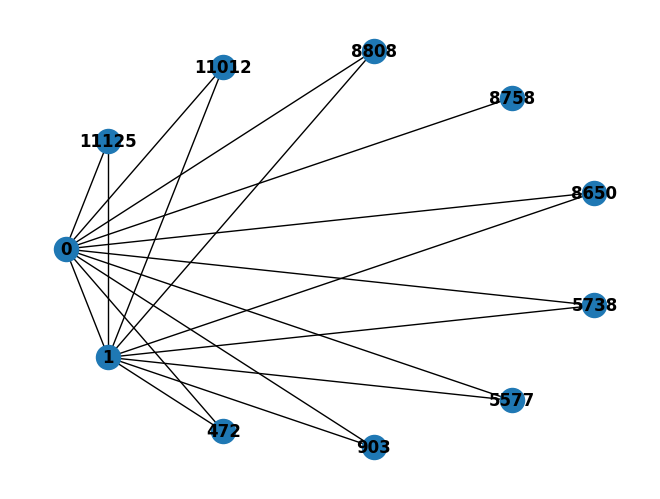

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

nx.draw_shell(G, with_labels=True, font_weight='bold')
plt.show()


In [ ]:
# https://networkx.org/documentation/stable/auto_examples/3d_drawing/plot_basic.html#sphx-glr-auto-examples-3d-drawing-plot-basic-py

# 3d matplotlib

In [ ]:
graph.degrees()

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()


# #Additional Info when using cuda
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')